# Segmenting and Clustering Neighborhoods in Toronto

_Anna A. Stepanova, Ph.D_

## Introduction

In this project, I will scrape the web data using a package *BeautifulSoup*. Then, I'll get the neighborhood information data from web, convert addresses into their equivalent latitude and longitude values. Also, I will use the Foursquare API to explore neighborhoods in Torono. I will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the *k*-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

## Table of Contents


1. [Scrape Wikipedia Page](#item1)
2. [Add Geospatial Data](#item2)
3. [Segmentation and Clustering Neighborhoods in Toronto](#item3)



Let's download required packages before we explore the data

In [1]:
#!pip install pandas

In [2]:
#!pip install folium

In [3]:
# install wordcloud
!pip install wordcloud

In [4]:
import numpy as np # library to handle data in a vectorized manner

#!pip install --user pandas==1.0.3

import pandas as pd # library for data analsysis


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup # web scrapping library

#import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

print('Libraries imported.')

Libraries imported.


<a id="item1"></a>
## 1. Scrape Wikipedia Page

Let's build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes, boroughs and neighborhoods.
We'll use BeautifulSoup library to extract the table from the web-page.

In [5]:
# import the library we use to open URLs
import urllib.request

# specify the URL of the Wikipedia page page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

Using the *urllib.request* library, we want to query the page and put the HTML data into a variable (which we have called ‘url’):

In [6]:
page = urllib.request.urlopen(url)

Then we use Beautiful Soup to parse the HTML data we stored in our ‘url’ variable and store it in a new variable called ‘soup’ in the Beautiful Soup format. We use the “lxml” library option:

In [7]:
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")

Extract the table data from the xml using class "wikitable sortable":

In [8]:
# find and extract table data from the Wikipedia page
table=soup.find('table', class_='wikitable sortable')

Now that the table has been found, let's use BeautifulSoup to extract rows into 3 future columns. Then we'll use *pandas* to create a data frame. All entries end up with new lines **\n** which we should replace prior to further analysis. We will exclude cells with a borough that is **Not assigned** and reset the indexes in a modified data frame. 
Let's print first 12 rows

In [9]:
### Let's get column data
#Initialize the columns
A=[]
B=[]
C=[]


for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        
#### Now let's create a data frame using pandas library
tor=pd.DataFrame(A,columns=['PostalCode'])
tor['Borough']=B
tor['Neighborhood']=C


# First filter out those rows which 
# does not contain any data 
tor = tor.dropna(how = 'all')

# Remove \n from data frame
tor = tor.replace('\n','', regex=True)

### Drop rows Not assigned
tor.drop(tor[tor['Borough'] == 'Not assigned'].index, inplace = True)

### print the data frame resetting the index
tor.reset_index(drop=True, inplace = True)

### Print the modified dataframe 
tor.head(12)
     


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


The dataframe consists of three columns: PostalCode, Borough, and Neighborhood and 103 entries for these columns.

In [10]:
### print the shape of the data frame
print(tor.shape)


(103, 3)


<a id="item2"></a>
## 2. Add Geospatial Data

In this part, we'll get the latitude and longitude coordinates of a given postal code using *Geocoder* package: NOT WORKING

As I was not able to get the geographical coordinates of the neighborhoods using the Geocoder package, I used a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

In [11]:
### Read Geospatial information from csv
postal_data = pd.read_csv('http://cocl.us/Geospatial_data')

postal_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we can create a new data frame containing information about neighborhoods and their coordinates by merging Neighborhood data with Geospatial data. First 12 rows printed

In [12]:
# Merge toronto data frame with postal_data
geo_tor = tor.merge(postal_data, left_on='PostalCode', right_on='Postal Code')

# drop repetitive Postal Code
geo_tor.drop(["Postal Code"], axis = 1, inplace = True)

# Print first 12 rows
geo_tor.head(12)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Our new data frame contains 103 entries and now has neighborhood coordinates.

In [13]:
### print the shape of the data frame
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(geo_tor['Borough'].unique()),
        geo_tor.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [14]:
### Let's see the borough names
print("The list of Toronto boroughs:\n")
for borough in geo_tor['Borough'].unique():
    print(borough)

The list of Toronto boroughs:

North York
Downtown Toronto
Etobicoke
Scarborough
East York
York
East Toronto
West Toronto
Central Toronto
Mississauga


For further analysis let's keep only boroughs containing a word Toronto in a data frame *neighborhoods*. Reset the indexes.

In [15]:
#### subset a neighborhood data frame keeping only Toronto neighborhoods

toronto = geo_tor[geo_tor.Borough.str.contains('Toronto',case=False)].reset_index(drop=True)

toronto.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [16]:
### print the shape of the data frame
print('The toronto dataframe has {} boroughs ({}) and {} neighborhoods.'.format(
        len(toronto['Borough'].unique()),
        ', '.join(map(str, toronto['Borough'].unique())),
        toronto.shape[0]
    )
)

The toronto dataframe has 4 boroughs (Downtown Toronto, East Toronto, West Toronto, Central Toronto) and 39 neighborhoods.


<a id="item3"></a>
## 3. Clustering Neighborhoods in Toronto

In this final section, we'll use Foursquare API to cluster neighborhoods in Toronto and **Folium** package to create maps. To get an idea about neighborhoods clusters, we'll plot most frequent venues in each clusted as barplots using **Matplotlib** package and we will also plot names of unique venues for each cluster usint **WordCloud**

#### Use geopy library to get the latitude and longitude values of Toronto.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [17]:
address = 'Toronto'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], 
                                           toronto['Longitude'], 
                                           toronto['Borough'], 
                                           toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials

In [28]:
# The code was removed by Watson Studio for sharing.

Let's explore the 7th neighborhood in our Toronto data frame. The code below will print the neighborhood name and its coordinates.

In [20]:
# print neighborhood name
neighborhood_name = toronto.loc[6, 'Neighborhood'] # neighborhood name

print('The 7th neighborhood in a cleaned Toronto data frame is {}.'.format(neighborhood_name))

# find neighborhood coordinates
neighborhood_latitude = geo_tor.loc[6, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = geo_tor.loc[6, 'Longitude'] # neighborhood longitude value


print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               round(neighborhood_latitude, 2), 
                                                               round(neighborhood_longitude, 2)))

The 7th neighborhood in a cleaned Toronto data frame is Central Bay Street.
Latitude and longitude values of Central Bay Street are 43.81, -79.19.


#### Now, let's get the top 100 venues that are in Central Bay Street within a radius of 600 meters.

First, let's create the GET request URL. Name your URL **url**.

In [21]:
# type your answer here
search_query = neighborhood_name
radius = 600 # define the radius
LIMIT = 100 # limit of number of venues returned by Foursquare API
print(search_query + ' .... OK!')


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    VERSION,
    radius, 
    LIMIT)



Central Bay Street .... OK!


Now we are ready to send our GET request and examine the resutls

In [22]:
results = requests.get(url).json()
#results

Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues[filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(15)

,name,categories,lat,lng
0,Images Salon & Spa,Spa,43.802283,-79.198565
1,Wendy’s,Fast Food Restaurant,43.807448,-79.199056
2,Wendy's,Fast Food Restaurant,43.802008,-79.198080
3,Lee Valley,Hobby Shop,43.803161,-79.199681


Let's see how many venues were returned by Foursquare

In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


### Exploring Neighborhoods in Toronto

Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's apply the function to all 39 neighborhoods in Toronto:

In [31]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


Let's explore the shape and head of a created data frame

In [32]:
print(toronto_venues.shape)
toronto_venues.head()

(2113, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


Let's check how many venues were returned for each neighborhood

In [33]:
toronto_venues[['Neighborhood', 'Venue']].groupby('Neighborhood').count()

,Venue
Neighborhood,
Berczy Park,92
"Brockton, Parkdale Village, Exhibition Place",41
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",22
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16
Central Bay Street,100
Christie,19
Church and Wellesley,100
"Commerce Court, Victoria Hotel",100
Davisville,46


Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 257 unique categories.


### Analyze Each Neighborhood

The code below will perform one hot encoding of Venue Categories in order to find the frequency of each category.

In [35]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
mid = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1, inplace = True)
toronto_onehot.insert(0, 'Neighborhood', mid)


toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [36]:
toronto_onehot.shape

(2113, 257)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.00,0.0000,0.0000,0.000,0.000,0.000,0.01087,0.0,0.0,0.01087,0.0,0.0,0.01087,0.00,0.00000,0.0,0.000000,0.01087,0.000000,0.01087,0.021739,0.0,0.01087,0.0,0.01087,0.01087,0.0,0.021739,0.000000,0.0,0.0,0.01087,0.0,0.0000,0.00,0.0,0.0,0.021739,0.000000,0.00,0.0,0.00,0.000000,0.0,0.0,0.043478,0.0,0.0,0.000000,0.0,0.00,0.021739,0

The new size of a grouped data frame is:

In [38]:
toronto_grouped.shape

(39, 257)

To put these data in a data frame, let's write a function to sort the venues in descending order.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 7 venues for each neighborhood.

In [40]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Berczy Park,Coffee Shop,Seafood Restaurant,Café,Cocktail Bar,Restaurant,Japanese Restaurant,Hotel
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Gift Shop,Breakfast Spot,Sandwich Place,Restaurant,Yoga Studio
2,"Business reply mail Processing Centre, South C...",Park,Burrito Place,Yoga Studio,Restaurant,Beer Store,Steakhouse,Brewery
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Coffee Shop,Harbor / Marina,Rental Car Location,Airport
4,Central Bay Street,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Sandwich Place,Italian Restaurant,Bar


### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 6 clusters.

In [41]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 3, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [42]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_grouped with toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sandwich Place,Park,Sushi Restaurant,Burrito Place,Café,Falafel Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Tea Room,Bookstore
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Gastropub,Italian Restaurant,Cosmetics Shop,Bakery
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Gastropub,Health Food Store,Breakfast Spot,Mexican Restaurant,French Restaurant,Bakery


Finally, let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'], 
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In order to characterize each cluster, let's create a bar graph of most common venues found in each cluster. Let's convert *toronto_merged* data frame from wide to long format.

In [44]:
## try converting toronto_merged from wide to long 
cluster_venue = toronto_merged[toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

cluster_venue = pd.melt(cluster_venue, id_vars=['Cluster Labels', 'Borough', 'Neighborhood'], #value_vars=['B'], 
        var_name='Rating', value_name='Venue').replace(' Most Common Venue','', regex=True)

cluster_venue.head()

,Cluster Labels,Borough,Neighborhood,Rating,Venue
0,1,Downtown Toronto,"Regent Park, Harbourfront",1st,Coffee Shop
1,1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",1st,Coffee Shop
2,1,Downtown Toronto,"Garden District, Ryerson",1st,Coffee Shop
3,1,Downtown Toronto,St. James Town,1st,Coffee Shop
4,1,East Toronto,The Beaches,1st,Pub


In [45]:
print('There are {} unique categories.'.format(len(cluster_venue['Venue'].unique())))

There are 87 unique categories.


#### Analyze each cluster

The code below will perform one hot encoding of Venues in order to find the frequency of each venue category among clusters.

In [46]:
# one hot encoding
cluster_onehot = pd.get_dummies(cluster_venue[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cluster_onehot['Cluster Labels'] = cluster_venue['Cluster Labels'] 

# move neighborhood column to the first column
mid = cluster_onehot['Cluster Labels'] 
cluster_onehot.drop(labels=['Cluster Labels'], axis=1, inplace = True)
cluster_onehot.insert(0, 'Cluster Labels', mid)


cluster_onehot.head()

,Cluster Labels,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Café,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Cosmetics Shop,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,French Restaurant,Garden,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Harbor / Marina,Health Food Store,Home Service,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Light Rail Station,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pub,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shoe Store,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tea Room,Tennis Court,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's group rows by Cluster Labels and find frequency of each Venue

In [47]:
cluster_grouped = cluster_onehot.groupby('Cluster Labels').mean()
cluster_grouped

,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Café,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Cosmetics Shop,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,French Restaurant,Garden,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Harbor / Marina,Health Food Store,Home Service,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Light Rail Station,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pub,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shoe Store,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tea Room,Tennis Court,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857
1,0.000000,0.000000,0.000000,0.000000,0.012987,0.004329,0.004329,0.004329,0.030303,0.008658,0.021645,0.004329,0.004329,0.012987,0.021645,0.021645,0.008658,0.004329,0.012987,0.000000,0.121212,0.004329,0.008658,0.004329,0.108225,0.004329,0.008658,0.004329,0.004329,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,0.000000,0.012987,0.004329,0.004329,0.004329,0.004329,0.004329,0.000000,0.008658,0.004329,0.008658,0.004329,0.008658,0.017316,0.000000,0.004329,0.000000,0.030303,0.004329,0.038961,0.038961,0.000000,0.004329,0.012987,0.004329,0.004329,0.043290,0.004329,0.004329,0.000000,0.025974,0.004329,0.004329,0.030303,0.000000,0.060606,0.030303,0.017316,0.008658,0.004329,0.004329,0.004329,0.030303,0.000000,0.004329,0.000000,0.004329,0.008658,0.000000,0.004329,0.004329,0.017316
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857
3,0.142857,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

Let's try to create a function for plotting the bar graphs with sorted frequencies


In [48]:
def plot_top_venues(df, clst, top_n = 15):
    

    # step 1: subset the data
    df_plot = (df.loc[clst,].to_frame()*100).round(2)

    #rename columns
    df_plot.columns = ['Percentage']

    # drop missing Venue Categories
    df_plot.drop(df_plot[df_plot['Percentage'] == 0.00].index, inplace = True)

    # Sort values based on Percentage and select top n
    df_plot.sort_values(['Percentage'], ascending = False, axis = 0, inplace=True)


    df_plot = df_plot[0:top_n]
    
    # step 2: plot data
    

    # highlight top 3 categories using different color
    colors =  'r' * 3 + 'c'* (top_n - 3)

    plt.figure(figsize=(15, 10))
    ax = df_plot.plot(kind='barh', 
                      figsize=(10, 5),
                      color= colors,
                      width=0.8,
                     fontsize = 20)


    ax.set_title('Top {} Venues in Cluster {}'.format(top_n, clst), fontsize = 20) # add title to the plot

    # add % sign
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    # remove legend
    plt.legend().set_visible(False)
    

Apply this function to all clusters in the *cluster_grouped* data frame

<Figure size 1080x720 with 0 Axes>

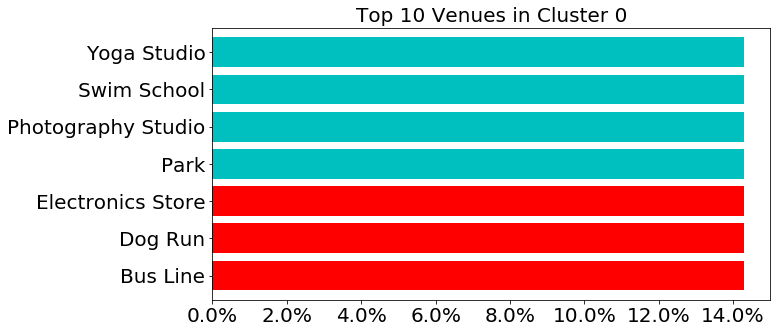

<Figure size 1080x720 with 0 Axes>

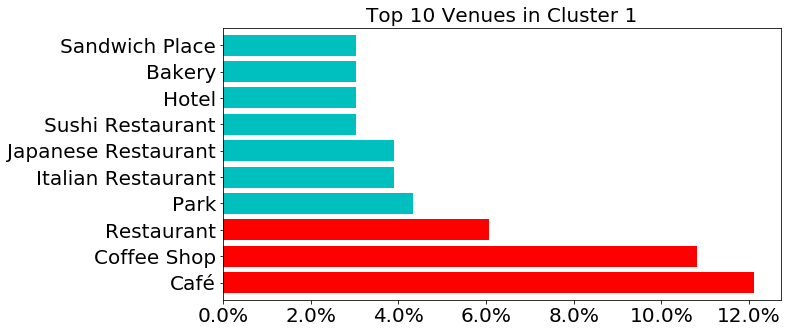

<Figure size 1080x720 with 0 Axes>

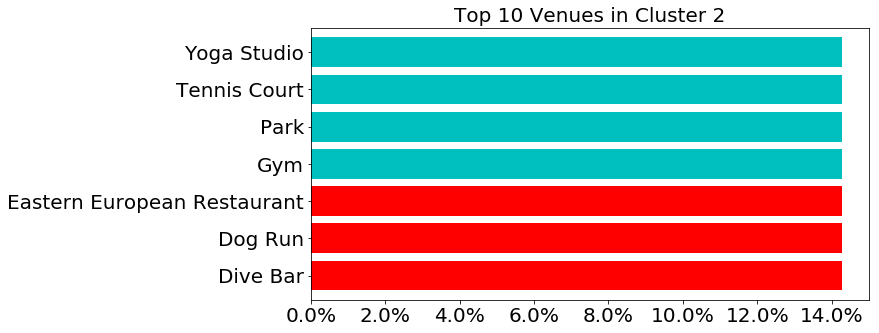

<Figure size 1080x720 with 0 Axes>

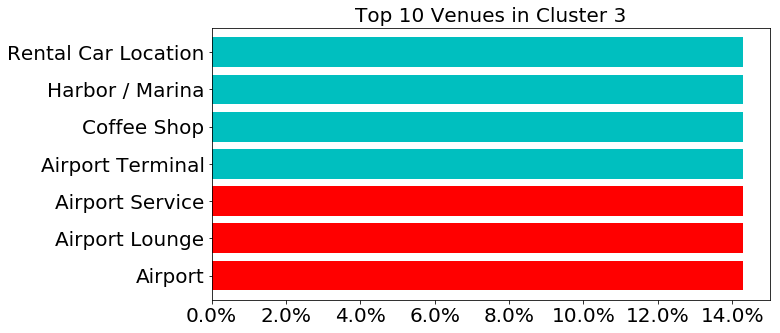

<Figure size 1080x720 with 0 Axes>

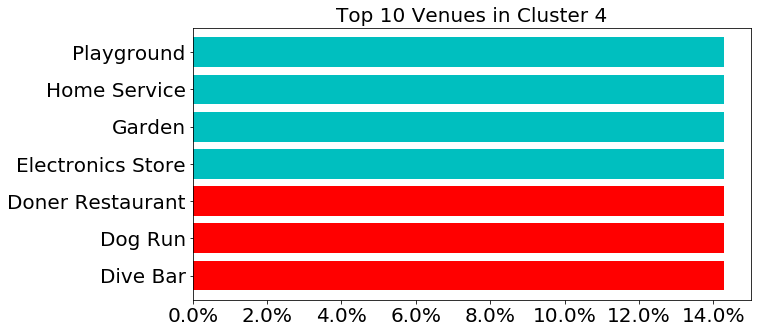

<Figure size 1080x720 with 0 Axes>

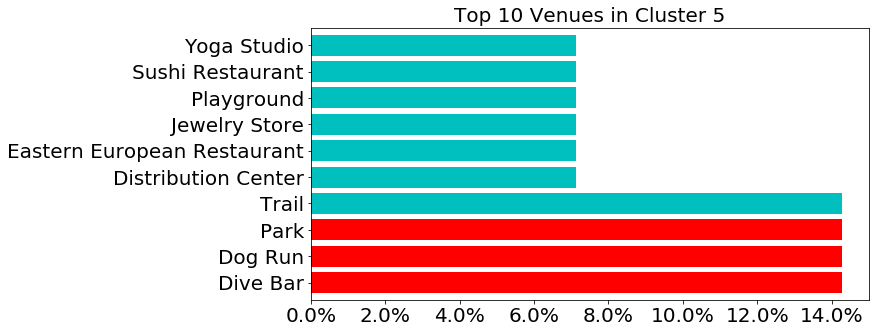

In [49]:
for i in cluster_grouped.index:
    plot_top_venues(df = cluster_grouped, clst = i, top_n = 10)

That gave us a general idea about the clusters. However, we can't see what makes the clusters unique. Let's try to find unique venues in each cluster.

In [50]:
# make a list of venues found in only one cluster
venue_unique=(cluster_grouped > 0).T.sum(axis = 1)

# keep only venues found in one and only one cluster
venue_unique = venue_unique[venue_unique==1].index.values

Let's try to draw word clouds to map unique venue categories in each cluster

In [51]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [52]:
# use one hot data frame to count the Venues
cluster_grouped_count = cluster_onehot.groupby('Cluster Labels').sum()
cluster_grouped_count

,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Café,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Cosmetics Shop,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,French Restaurant,Garden,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Harbor / Marina,Health Food Store,Home Service,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Light Rail Station,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,Park,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pub,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shoe Store,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tea Room,Tennis Court,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,3,1,1,1,7,2,5,1,1,3,5,5,2,1,3,0,28,1,2,1,25,1,2,1,1,0,0,0,0,1,0,0,3,1,1,1,1,1,0,2,1,2,1,2,4,0,1,0,7,1,9,9,0,1,3,1,1,10,1,1,0,6,1,1,7,0,14,7,4,2,1,1,1,7,0,1,0,1,2,0,1,1,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,1


Now, let's write a function that will create word clouds of unique venues for each cluster.

In [53]:
def wordcloud_unique_venues(df, clst, venue_unique = venue_unique):
    
    # step 1: subset the data frame
    #df = cluster_grouped_count

    df1 = cluster_grouped_count>0


    df_cloud = df1.loc[clst,].to_frame()

    #rename columns
    df_cloud.columns = ['Present']

    # drop missing Venue Categories
    df_cloud.drop(df_cloud[df_cloud['Present'] == False].index, inplace = True)

    # keep only venues from unique_venue_list
    df_cloud = df_cloud.loc[df_cloud.index.intersection(venue_unique)]

    ## save a list of unique venues for a cluster
    venue_unique_cluster = df_cloud.index.values
    
    
    ### step 2: make a string for word cloud
    max_words = 90
    word_string = ''
    for venue in venue_unique_cluster:
            repeat_num_times = cluster_grouped_count.loc[clst, venue]
            word_string = word_string + ((venue.replace(' ', '_') + ' ') * repeat_num_times)

    ### step 3: create a word cloud
    wordcloud = WordCloud(background_color='white', collocations=False).generate(word_string)

    # display the cloud
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    plt.title('\n\nUnique Venues in Cluster {}'.format(clst), fontsize = 20) # add title to the plot
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.show()


Let's apply this function to all clusters

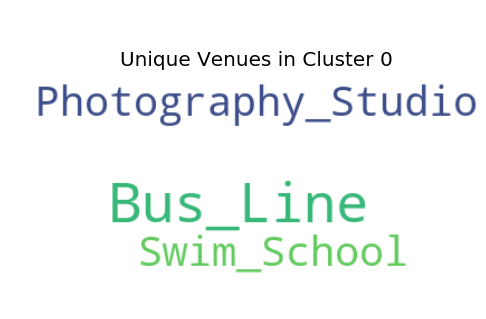

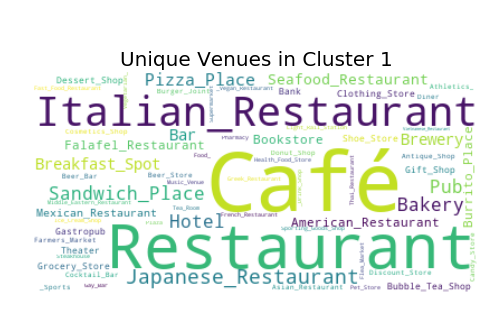

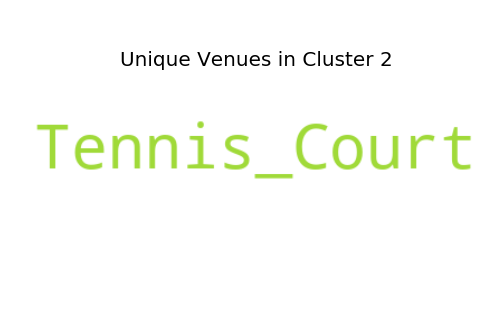

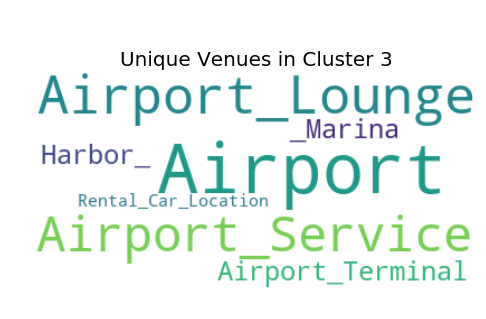

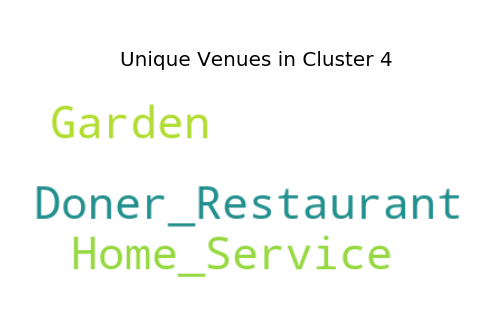

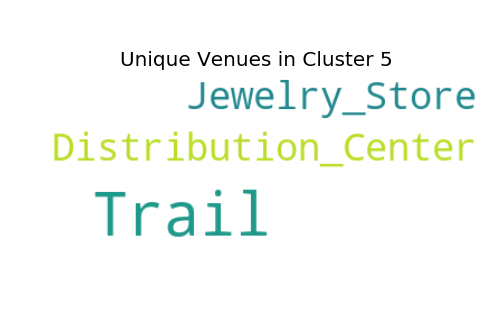

In [54]:
for i in cluster_grouped_count.index:
    wordcloud_unique_venues(df = cluster_grouped_count, clst = i, venue_unique = venue_unique)

This approach worked much better in characterizing cluster properties